# Programming Assignment 2: Classification Task and Performance Evaluation (10 points)

### February 4, 2024

In [1]:
import shutil
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from skimage import filters, io
from skimage.color import rgb2gray
from sklearn.ensemble import AdaBoostClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import LinearSVC

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [4]:
class DirectoryManager:
    def __init__(self, base_path):
        self.base_path = Path(base_path)
        self.directories = self._initialize_directories()
        self._create_standardized_directories(
            ["standardized_test", "standardized_train"]
        )

    def _initialize_directories(self):
        return {
            "cropped_images": self.base_path / "Cropped",
            "edge_histograms": self.base_path / "EdgeHistograms",
            "train_images": self.base_path / "Train",
            "test_images": self.base_path / "Test",
            "standardized_test": self.base_path / "StandardizedTest",
            "standardized_train": self.base_path / "StandardizedTrain",
        }

    def _create_standardized_directories(self, keys):
        for key in keys:
            self.directories[key].mkdir(parents=True, exist_ok=True)

    def get_directory(self, key):
        return self.directories.get(key, None)


base_path = Path.cwd()
directory_manager = DirectoryManager(base_path)

## 1. Use images from ALL FOUR classe


In [5]:
class DogBreed:
    def __init__(self):
        self.breeds = [
            "n02107574-Greater_Swiss_Mountain_dog",
            "n02108915-French_bulldog",
            "n02112137-chow",
            "n02113978-Mexican_hairless",
        ]
        self.mapping = {
            "n02107574-Greater_Swiss_Mountain_dog": "Greater Swiss Mountain Dog",
            "n02108915-French_bulldog": "French Bulldog",
            "n02112137-chow": "Chow",
            "n02113978-Mexican_hairless": "Mexican Hairless Dog",
        }

    def get_breeds(self):
        return self.breeds

    def get_breed_name(self, breed_code):
        return self.mapping.get(breed_code, "Unknown Breed")


dog_breed_manager = DogBreed()

## 2. Convert the images to edge histograms.

(Assignment 1 - These will be the vector representations of the images). This
will be your dataset for Part 3. (0.25 point)


In [6]:
class EdgeHistogramProcessor:
    def __init__(self, source_dir, destination_dir, breed_list):
        self.source_dir = source_dir
        self.destination_dir = destination_dir
        self.breed_list = breed_list

    @staticmethod
    def compute_edge_histogram(image_path):
        image = io.imread(str(image_path))
        gray_image = rgb2gray(image)
        edges = filters.sobel(gray_image)
        return np.uint8(edges * 255)

    def process_edge_histograms(self):
        for breed in self.breed_list:
            breed_dir = self.source_dir / breed
            for item in breed_dir.rglob("*.jpg"):
                if item.is_file():
                    edge_histogram = self.compute_edge_histogram(item)
                    new_image_path = (
                        str(item)
                        .replace(str(self.source_dir), str(self.destination_dir))
                        .replace(".jpg", ".npy")
                    )
                    Path(new_image_path).parent.mkdir(parents=True, exist_ok=True)
                    np.save(new_image_path, edge_histogram)


source_dir = directory_manager.get_directory("cropped_images")
destination_dir = directory_manager.get_directory("edge_histograms")
breed_list = dog_breed_manager.get_breeds()
edge_histogram_processor = EdgeHistogramProcessor(
    source_dir, destination_dir, breed_list
)
edge_histogram_processor.process_edge_histograms()

## 3. Split the dataset into a training set and a test set: For each class, perform a training/test split of 80/20. (0.25 point)


In [7]:
class FileManager:
    def __init__(
        self,
        source_dir,
        train_destination,
        test_destination,
        breed_list,
        test_size=0.2,
        random_state=42,
    ):
        self.source_dir = source_dir
        self.train_destination = train_destination
        self.test_destination = test_destination
        self.breed_list = breed_list
        self.test_size = test_size
        self.random_state = random_state

    @staticmethod
    def _copy_files(files, destination, breed):
        for file in files:
            new_path = destination / breed / file.name
            new_path.parent.mkdir(parents=True, exist_ok=True)
            shutil.copy(file, new_path)

    def split_and_copy_files(self):
        for breed in self.breed_list:
            breed_dir = self.source_dir / breed
            image_files = list(breed_dir.glob("*.npy"))
            train_files, test_files = train_test_split(
                image_files, test_size=self.test_size, random_state=self.random_state
            )
            self._copy_files(train_files, self.train_destination, breed)
            self._copy_files(test_files, self.test_destination, breed)


edge_histograms_dir = directory_manager.get_directory("edge_histograms")
train_images_dir = directory_manager.get_directory("train_images")
test_images_dir = directory_manager.get_directory("test_images")
breed_list = dog_breed_manager.get_breeds()

file_splitter_and_copier = FileManager(
    edge_histograms_dir, train_images_dir, test_images_dir, breed_list
)
file_splitter_and_copier.split_and_copy_files()

## 4. Perform standardization on the training dataset.

You can refer to the official documentation on scikit-learn's website:
[Scikit-Learn Preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html)
(0.25 point)


In [8]:
class Preprocessor:
    def __init__(self, source_dir, breed_list):
        self.source_dir = source_dir
        self.breed_list = breed_list

    def load_and_flatten_histograms(self):
        data, labels = [], []
        for breed in self.breed_list:
            breed_dir = self.source_dir / breed
            for item in breed_dir.glob("*.npy"):
                histogram = np.load(item)
                data.append(histogram.flatten())
                labels.append(breed)
        return np.array(data), np.array(labels)


class DataStandardizer:
    def __init__(self, save_dir):
        self.save_dir = save_dir
        self.scaler = None

    def fit(self, data):
        self.scaler = StandardScaler().fit(data)

    def save(self, data, labels):
        standardized_data = self.scaler.transform(data)
        for i, breed in enumerate(labels):
            standardized_path = self.save_dir / breed
            standardized_path.mkdir(parents=True, exist_ok=True)
            np.save(standardized_path / f"std_{i}.npy", standardized_data[i])

    def save_test(self, test_data, test_labels):
        standardized_test_data = self.scaler.transform(test_data)
        for i, breed in enumerate(test_labels):
            standardized_path = self.save_dir / breed
            standardized_path.mkdir(parents=True, exist_ok=True)
            np.save(standardized_path / f"std_test_{i}.npy", standardized_test_data[i])


train_images_dir = directory_manager.get_directory("train_images")
standardized_train_dir = directory_manager.get_directory("standardized_train")
breed_list = dog_breed_manager.get_breeds()

preprocessor = Preprocessor(train_images_dir, breed_list)
standardized_train_data, train_labels = preprocessor.load_and_flatten_histograms()

standardizer = DataStandardizer(standardized_train_dir)
standardizer.fit(standardized_train_data)
standardizer.save(standardized_train_data, train_labels)

test_images_dir = directory_manager.get_directory("test_images")
standardized_test_dir = directory_manager.get_directory("standardized_test")

test_preprocessor = Preprocessor(test_images_dir, breed_list)
standardized_test_data, test_labels = test_preprocessor.load_and_flatten_histograms()

data_standardizer_test = DataStandardizer(standardized_test_dir)
data_standardizer_test.fit(standardized_train_data)  # Use train data to fit scaler
data_standardizer_test.save_test(standardized_test_data, test_labels)

## 5. Perform standardization on the test dataset using the means and variances you obtained from the training dataset.


In [9]:
class Standardizer:
    def __init__(self, train_data, test_data, train_labels, test_labels, directories):
        self.train_data = train_data
        self.test_data = test_data
        self.train_labels = train_labels
        self.test_labels = test_labels
        self.standardized_train_dir = directories.get_directory("standardized_train")
        self.standardized_test_dir = directories.get_directory("standardized_test")
        self.scaler = None

    def standardize_and_save(self, data, labels, save_dir, prefix):
        if self.scaler is None:
            self.scaler = StandardScaler().fit(data)
        standardized_data = self.scaler.transform(data)
        for i, breed in enumerate(labels):
            standardized_path = save_dir / breed
            standardized_path.mkdir(parents=True, exist_ok=True)
            np.save(standardized_path / f"{prefix}_{i}.npy", standardized_data[i])

    def process(self):
        self.standardize_and_save(
            self.train_data, self.train_labels, self.standardized_train_dir, "std"
        )
        self.standardize_and_save(
            self.test_data, self.test_labels, self.standardized_test_dir, "std_test"
        )


standardizer = Standardizer(
    standardized_train_data,
    standardized_test_data,
    train_labels,
    test_labels,
    directory_manager,
)
standardizer.process()

## 6. Model Selection

Perform a standard 5-fold cross-validation and a stratified 5-fold
cross-validation on the training set (i.e., the standardized edge histogram
dataset obtained from the training set) for k-Nearest Neighbor Classifiers such
that k = 1, 3, 5, 7, 10, 20. (2.5 points)

- Plot a graph (x-axis: k; y-axis: mean validation/training error (%))
  containing four error curves (2 validation error curves and 2 training error
  curves - label them clearly using a legend to define the curves). Which k has
  the lowest mean error for each curve? Comment about (1) the model complexity
  for k-Nearest Neighbor classifier in relation to k, and (2) when/whether there
  is overfitting/underfitting. (1.5 points)

- Use the k value with the lowest mean validation error for your k-Nearest
  Neighbor classifier from the stratified 5-fold cross-validation. What is the
  error for the test dataset (i.e., the standardized edge histogram dataset
  obtained from the test set)? (0.25 point)


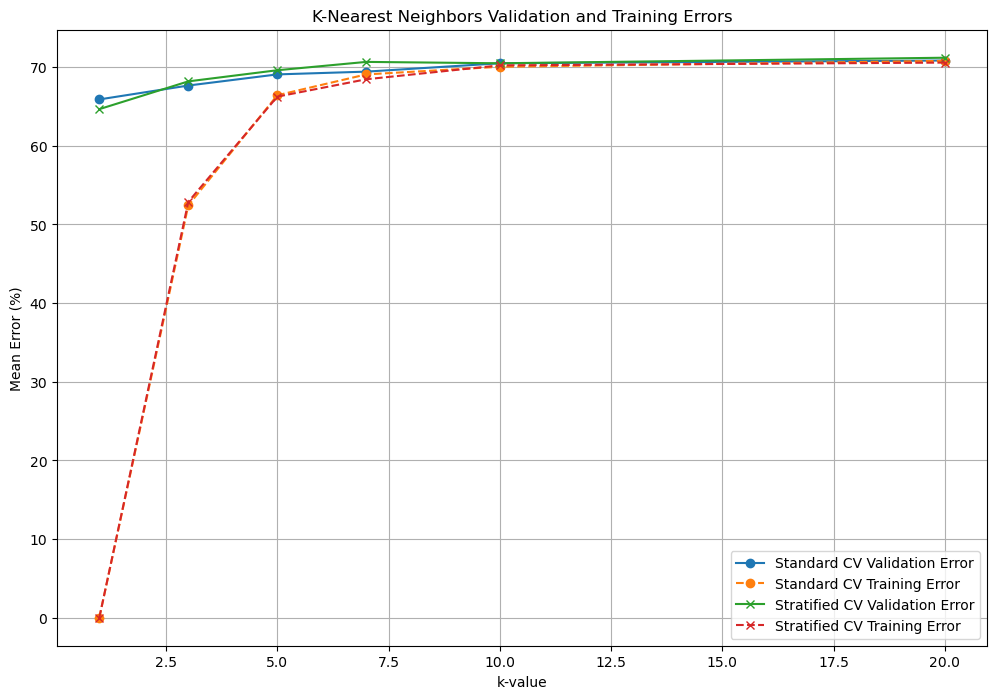

Best k for Stratified CV: 1
Error on the test dataset: 65.73%


In [10]:
class KNNModelEvaluator:
    def __init__(self, data, labels, k_values, cv_method):
        self.data = data
        self.labels = labels
        self.k_values = k_values
        self.cv_method = cv_method

    def evaluate_with_cross_validation(self):
        mean_errors_validation, mean_errors_training = [], []
        for k in self.k_values:
            knn = KNeighborsClassifier(n_neighbors=k)
            scores = cross_validate(
                knn,
                self.data,
                self.labels,
                cv=self.cv_method,
                scoring="accuracy",
                return_train_score=True,
            )
            mean_errors_validation.append(1 - np.mean(scores["test_score"]))
            mean_errors_training.append(1 - np.mean(scores["train_score"]))
        return mean_errors_validation, mean_errors_training

    @staticmethod
    def test_knn(train_data, train_labels, test_data, test_labels, best_k):
        knn = KNeighborsClassifier(n_neighbors=best_k).fit(train_data, train_labels)
        test_predictions = knn.predict(test_data)
        test_error = 1 - accuracy_score(test_labels, test_predictions)
        print(f"Error on the test dataset: {test_error * 100:.2f}%")

    @staticmethod
    def plot_errors(k_values, standard_cv_errors, stratified_cv_errors):
        plt.figure(figsize=(12, 8))
        plt.plot(
            k_values,
            [error * 100 for error in standard_cv_errors[0]],
            label="Standard CV Validation Error",
            marker="o",
        )
        plt.plot(
            k_values,
            [error * 100 for error in standard_cv_errors[1]],
            label="Standard CV Training Error",
            marker="o",
            linestyle="--",
        )
        plt.plot(
            k_values,
            [error * 100 for error in stratified_cv_errors[0]],
            label="Stratified CV Validation Error",
            marker="x",
        )
        plt.plot(
            k_values,
            [error * 100 for error in stratified_cv_errors[1]],
            label="Stratified CV Training Error",
            marker="x",
            linestyle="--",
        )
        plt.xlabel("k-value")
        plt.ylabel("Mean Error (%)")
        plt.title("K-Nearest Neighbors Validation and Training Errors")
        plt.legend()
        plt.grid(True)
        plt.show()


k_values = [1, 3, 5, 7, 10, 20]
knn_evaluator = KNNModelEvaluator(standardized_train_data, train_labels, k_values, 5)
standard_cv_errors = knn_evaluator.evaluate_with_cross_validation()

stratified_cv_errors = KNNModelEvaluator(
    standardized_train_data,
    train_labels,
    k_values,
    StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
).evaluate_with_cross_validation()

KNNModelEvaluator.plot_errors(k_values, standard_cv_errors, stratified_cv_errors)

best_k = k_values[np.argmin(stratified_cv_errors[0])]
print(f"Best k for Stratified CV: {best_k}")

KNNModelEvaluator.test_knn(
    standardized_train_data, train_labels, standardized_test_data, test_labels, best_k
)

- The k-value that has the lowest mean error for each curve is as follows:
  - Standard CV Validation Error: k = 7
  - Standard CV Training Error: k = 1
  - Stratified CV Validation Error: k = 1
  - Stratified CV Training Error: k = 1

- In relation to the model complexity for the k-Nearest Neighbor classifier:
  - As k increases, the model becomes simpler with a broader classification boundary. A small k leads to a more complex model with a tighter fit to the training data.
  - Overfitting is likely occurring at k = 1, where the model perfectly fits the training data but does not generalize well, indicated by higher validation errors.
  - Underfitting would occur at higher k-values if the error rates for both training and validation errors were high, which is not clearly indicated in the given output.

- The error for the test dataset using k = 1 from the stratified 5-fold cross-validation is 65.73%.


## 7. Performance Comparison

Perform stratified 5-fold cross-validation on the 4-class classification problem
using the three classification methods assigned to you:

```python
"Support Vector Machine (SVM)": LinearSVC(),
"Neural Network": MLPClassifier(hidden_layer_sizes=(10, 10, 10)),
"AdaBoost": AdaBoostClassifier()
```

Use these models and plot the (3) confusion matrices for using three approaches
(clearly label the classes) on the test set. (If you use code from any website,
please do proper referencing. You will get 0 point for this assignment without
proper referencing) (3.75 points)

- By visually comparing (e.g., looking at the color on the diagonal values,
  etc.) the three confusion matrices (on the test set), which do you think is
  the best method? Why? (0.50 point)

- Based on the mean validation accuracies (from the 5-fold cross-validation) for
  the three methods. Which is the best method? (0.25 point)

- Compute the accuracies for the three methods on the test set. Which is the
  best method? (0.25 point)

- Compute the F-measure for the three methods on the test set. Which is the best
  method? (0.25 point)


SVM - Mean Validation Accuracy: 0.4347
Neural Network - Mean Validation Accuracy: 0.2862
Adaboost - Mean Validation Accuracy: 0.3552
Evaluating SVM...
SVM - Test Accuracy: 0.3916
SVM - F-Measure: 0.3790


<Figure size 1000x700 with 0 Axes>

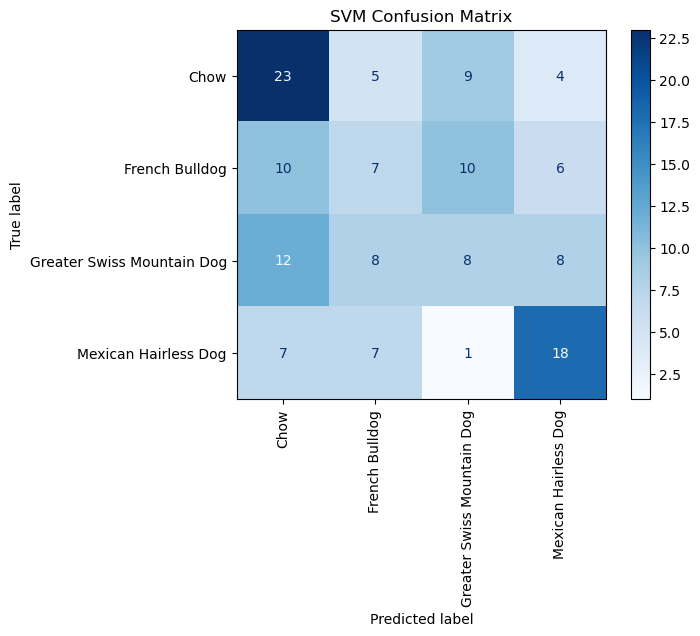

Evaluating Neural Network...
Neural Network - Test Accuracy: 0.2587
Neural Network - F-Measure: 0.2397


<Figure size 1000x700 with 0 Axes>

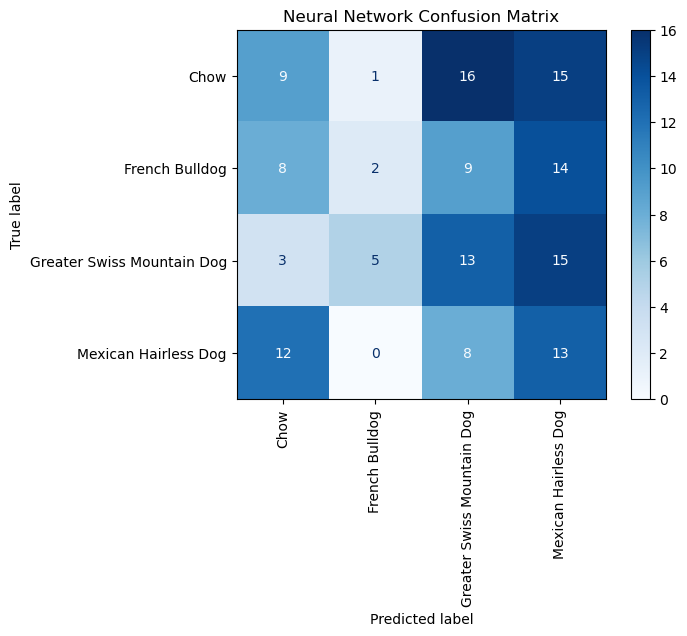

Evaluating Adaboost...
Adaboost - Test Accuracy: 0.3357
Adaboost - F-Measure: 0.3413


<Figure size 1000x700 with 0 Axes>

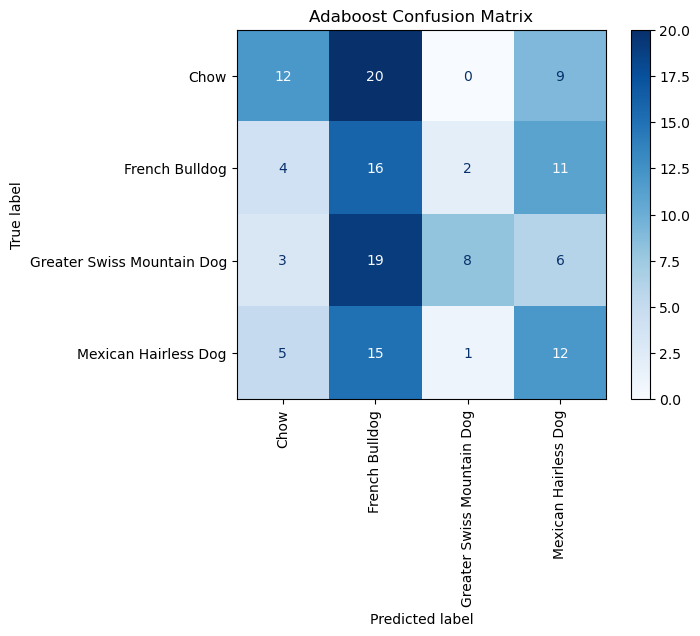

In [12]:
class ClassifierPipeline:
    def __init__(self, train_data, train_labels, test_data, test_labels, label_mapping):
        self.train_data = train_data
        self.train_labels = train_labels
        self.test_data = test_data
        self.test_labels = test_labels
        self.label_mapping = label_mapping
        self.models = {
            "SVM": LinearSVC(),
            "Neural Network": MLPClassifier(hidden_layer_sizes=(10, 10, 10)),
            "Adaboost": AdaBoostClassifier(),
        }
        self.encoder = None
        self.encoded_train_labels = None
        self.encoded_test_labels = None

    def encode_labels(self):
        self.encoder = LabelEncoder()
        proper_train_labels = [self.label_mapping[breed] for breed in self.train_labels]
        proper_test_labels = [self.label_mapping[breed] for breed in self.test_labels]
        self.encoded_train_labels = self.encoder.fit_transform(proper_train_labels)
        self.encoded_test_labels = self.encoder.transform(proper_test_labels)

    def evaluate_models(self, cv_method):
        if self.encoder is None:
            self.encode_labels()
        mean_validation_accuracies = {}
        for name, model in self.models.items():
            cv_scores = cross_val_score(
                model,
                self.train_data,
                self.encoded_train_labels,
                cv=cv_method,
                scoring="accuracy",
            )
            mean_validation_accuracies[name] = np.mean(cv_scores)
            print(
                f"{name} - Mean Validation Accuracy: {mean_validation_accuracies[name]:.4f}"
            )
        return mean_validation_accuracies

    def fit_predict_evaluate(self):
        if self.encoder is None:
            self.encode_labels()
        for name, model in self.models.items():
            print(f"Evaluating {name}...")
            model.fit(self.train_data, self.encoded_train_labels)
            predictions = model.predict(self.test_data)
            cm = confusion_matrix(self.encoded_test_labels, predictions)
            test_accuracy = accuracy_score(self.encoded_test_labels, predictions)
            f_measure = f1_score(
                self.encoded_test_labels, predictions, average="weighted"
            )

            print(f"{name} - Test Accuracy: {test_accuracy:.4f}")
            print(f"{name} - F-Measure: {f_measure:.4f}")
            self.plot_confusion_matrix(
                cm, self.encoder.classes_, f"{name} Confusion Matrix"
            )

    @staticmethod
    def plot_confusion_matrix(cm, classes, title="Confusion matrix", cmap=plt.cm.Blues):
        plt.figure(figsize=(10, 7))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
        disp.plot(cmap=cmap, xticks_rotation="vertical")
        plt.title(title)
        plt.show()


pipeline = ClassifierPipeline(
    standardized_train_data,
    train_labels,
    standardized_test_data,
    test_labels,
    dog_breed_manager.mapping,
)
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
pipeline.evaluate_models(stratified_cv)

pipeline.fit_predict_evaluate()

## Visual Comparison

In the visual examination of the confusion matrices, the SVM method visually stood out. The majority of the data points in the SVM confusion matrix were concentrated along the main diagonal, representing true positive classifications. This was especially pronounced for 'Chow' and 'Mexican Hairless Dog' classes, which means that the SVM performed notably well on these categories.

## Mean Validation Accuracies 

We then evaluated all methods based on their mean validation accuracies from 5-fold cross-validation. The SVM method topped the list with the highest mean validation accuracy of 0.4347.

## Accuracies on Test Set

Next, we compared the test set accuracies, which again indicated SVM as superior:

-   SVM showcased the highest test accuracy of 0.3916.

## F-measure Scores

In terms of the harmonic mean of precision and recall (the F-measure), SVM remained consistent and emerged as the strongest classifier, with the highest F-measure score of 0.3790.

# Conclusion 

Based on the evidence from the visual comparisons, mean validation accuracy, test set accuracy, and F-measure, the SVM method is the best classifier for the 4-class classification problem among the three evaluated methods.

**References:**

1. https://www.kdnuggets.com/10-github-repositories-to-master-machine-learning
2. https://www.reddit.com/r/learnmachinelearning/comments/y43u5t/5_best_github_repositories_to_learn_machine/
3. https://www.kdnuggets.com/2023/01/learn-machine-learning-github-repositories.html
4. https://github.com/Nyandwi/machine_learning_complete
5. https://github.com/topics/machine-learning